In [444]:
import numpy as np
import pandas as pd
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import Model
from keras import Input
from keras.layers import LSTM, Dense, Dropout

from sklearn.metrics import mean_absolute_error


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [445]:
df = pd.read_csv('기온예측변수.csv',encoding=('cp949'))
df.isnull().sum()

일시            0
평균 풍속(m/s)    0
평균기압(hPa)     0
평균 상대습도(%)    0
평균 기온(°C)     0
dtype: int64

In [446]:
df

,일시,평균 풍속(m/s),평균기압(hPa),평균 상대습도(%),평균 기온(°C)
0,2013-01-01,8.90,1017.60,56.00,2.50
1,2013-01-02,12.10,1023.50,55.00,-0.90
2,2013-01-03,8.20,1030.00,59.00,-2.50
3,2013-01-04,3.80,1028.30,55.00,-0.10
4,2013-01-05,5.70,1021.00,49.00,3.00
...,...,...,...,...,...
10809,2022-12-27,3.30,1025.00,65.00,7.30
10810,2022-12-28,7.70,1024.80,50.00,5.80
10811,2022-12-29,9.00,1028.30,50.00,3.70
10812,2022-12-30,4.70,1028.40,51.00,4.60


In [447]:
df.dtypes

일시             object
평균 풍속(m/s)    float64
평균기압(hPa)     float64
평균 상대습도(%)    float64
평균 기온(°C)     float64
dtype: object

In [448]:
df['일시'] = pd.to_datetime(df['일시'])

In [449]:
df = df.groupby(df['일시'].dt.strftime("%Y-%m")).mean()

In [450]:
df.dtypes

평균 풍속(m/s)    float64
평균기압(hPa)     float64
평균 상대습도(%)    float64
평균 기온(°C)     float64
dtype: object

In [451]:
TRAIN_SPLIT = 84
tf.random.set_seed(10)

In [452]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000


In [453]:
EVALUATION_INTERVAL = 200
EPOCHS = 50

In [454]:
pd.options.display.float_format = '{: .2f}'.format

In [455]:
features_considered = ['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)']


In [494]:
features = df[features_considered]
features.shape

(120, 4)

array([<AxesSubplot:xlabel='일시'>, <AxesSubplot:xlabel='일시'>,
       <AxesSubplot:xlabel='일시'>, <AxesSubplot:xlabel='일시'>], dtype=object)

c:\Users\admin\anaconda2\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\admin\anaconda2\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\admin\anaconda2\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\admin\anaconda2\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\admin\anaconda2\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\admin\anacon

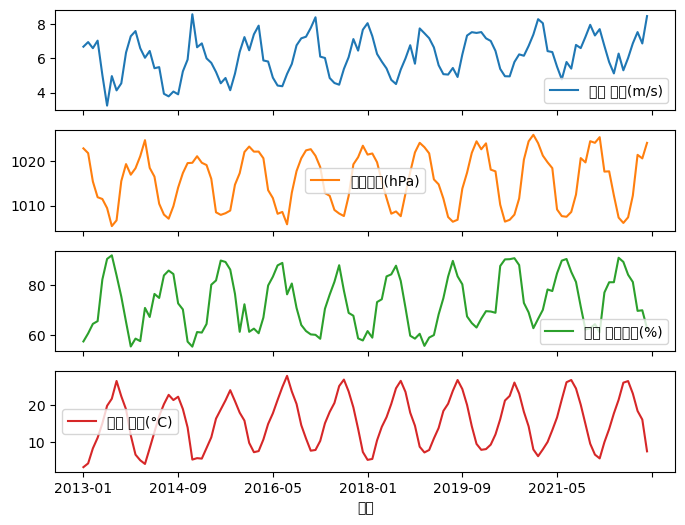

In [457]:
features.plot(subplots=True)

In [498]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
# 표준화
dataset = (dataset-data_mean)/data_std

dataset.shape

(120, 4)

In [459]:
def create_time_steps(length):
  return list(range(-length, 0))

In [460]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [500]:
data = []
for i in range(120, 120): # train(36, 84) / valid(120, 120)
    indices = range(i-36, i) # train((0, 36) ~ (47, 83)) / valid((48, 84) ~ (83, 119))
    # print(indices)
    data.append(dataset[indices])
data


[]

In [474]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = [] # train
  labels = [] # valid

  
  if end_index is None:
    end_index = len(dataset) # valid(120)
    start_index = start_index # train(36) / valid(120)
  else:
    start_index = start_index + history_size # train(36) / valid(120)

  for i in range(start_index, end_index): # train(36, 84) / valid(120, 120)
    indices = range(i-history_size, i) # train((0, 36) ~ (47, 83)) / valid((48, 84) ~ (83, 119))
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [475]:
past_history = 36
future_target = 12
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 3], 0,TRAIN_SPLIT, past_history,future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 3],TRAIN_SPLIT, None, past_history,future_target, STEP)

In [476]:
x_val_multi

array([], dtype=float64)

In [465]:
x_train_multi.shape

(48, 36, 4)

In [466]:
print('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (36, 4)

 Target temperature to predict : (12,)


In [467]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [468]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

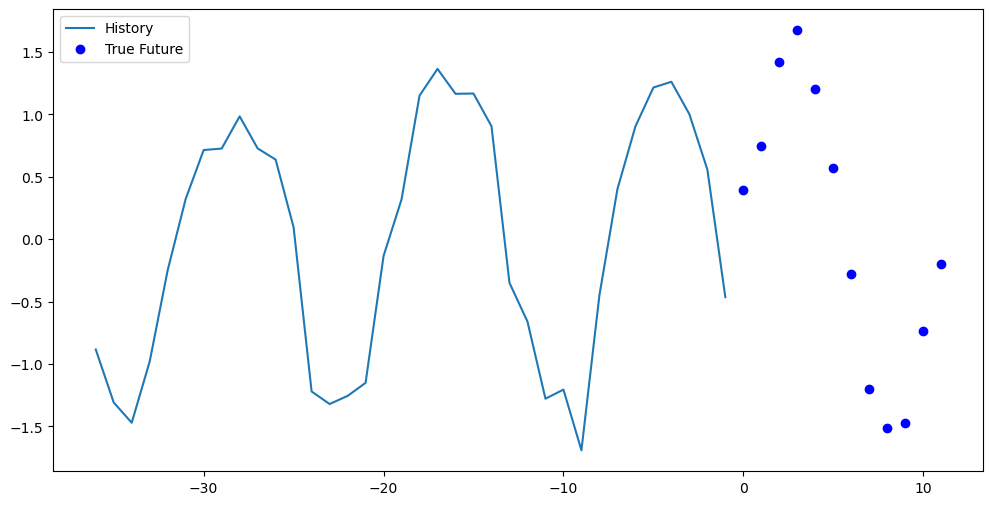

In [469]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [470]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(36,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(12))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [471]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

In [472]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/50
199/200 [============================>.] - ETA: 0s - loss: 0.3885

ValueError: in user code:

    File "c:\Users\admin\anaconda2\lib\site-packages\keras\engine\training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\admin\anaconda2\lib\site-packages\keras\engine\training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\admin\anaconda2\lib\site-packages\keras\engine\training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\admin\anaconda2\lib\site-packages\keras\engine\training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\admin\anaconda2\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\admin\anaconda2\lib\site-packages\keras\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_12' (type Sequential).
    
    Input 0 of layer "lstm_17" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_12' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float64)
      • training=False
      • mask=None
